In [1]:
# import the packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression

# Conceptual exercises

## Backfitting approach for GAMs

### Generate a response $Y$ and two predictors $X_{1}, X_{2}$ with $n=100$.

In [2]:
np.random.seed(30100)

X1 = np.random.normal(size=100)
X2 = np.random.normal(size=100)
eps = np.random.normal(size=100)
beta = np.random.uniform(0,4,size=3)

Y = beta[0] + beta[1]*X1 + beta[2]*X2 + eps

In [3]:
print("The simulated betas are: {}".format(beta))

The simulated betas are: [3.11845525 0.04921224 2.39379572]


### Initialize $\hat{\beta_{1}}$ to take on a value of your choice. It does not matter what value you choose

In [4]:
beta1 = 1

### Keeping $\hat{\beta_{1}}$ fixed, fit the model

In [5]:
y_reduced = (Y - beta1*X1)

In [6]:
ls = sm.OLS(y_reduced, sm.add_constant(X2)).fit()
print("The estimated coefficient of X2 is: {:.4f}".format(ls.params[1]))

The estimated coefficient of X2 is: 2.4621


### Keeping $\hat{\beta_{2}}$ fixed, fit the model

In [7]:
beta2 = ls.params[1]
y_reduced = (Y - beta2*X2)
ls = sm.OLS(y_reduced, sm.add_constant(X1)).fit()
print("The estimated coefficient of X1 is: {:.4f}".format(ls.params[1]))

The estimated coefficient of X1 is: 0.2134


### Write a for loop to repeat (c) and (d) 1000 times. Report the estimates for $\hat{\beta_{0}}, \hat{\beta_{1}}, \hat{\beta_{2}}$ at each iteration of the for loop. Create a plot in which each of these values is displayed, with $\hat{\beta_{0}}, \hat{\beta_{1}}, \hat{\beta_{2}}$ each shown in a different color.

In [8]:
X = sm.add_constant(np.vstack((X1, X2)).T)

In [9]:
beta0_lst = []; beta1_lst = []; beta2_lst = []
beta0 = beat1 = beta2 = 1
for i in range(1000):
    # estimate beta2
    beta2 = sm.OLS(Y-beta1*X[:,1], X[:,[0,2]]).fit().params[1]
    # estimate beta0, beta1
    beta0, beta1 = sm.OLS(Y-beta2*X[:,2], X[:,:2]).fit().params
    beta0_lst.append(beta0); beta1_lst.append(beta1); beta2_lst.append(beta2)

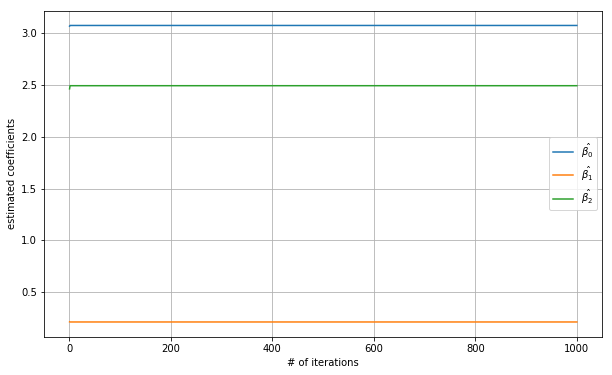

In [10]:
plt.figure(figsize=(10,6))
plt.plot(range(1,1001), beta0_lst, label = r'$\hat{\beta_{0}}$')
plt.plot(range(1,1001), beta1_lst, label = r'$\hat{\beta_{1}}$')
plt.plot(range(1,1001), beta2_lst, label = r'$\hat{\beta_{2}}$')
plt.xlabel("# of iterations"); plt.ylabel("estimated coefficients")
plt.grid()
plt.legend()
plt.show()

### Compare your answer in (e) to the results of simply performing multiple linear regression to predict $Y$ using $X_{1}$ and $X_{2}$. Overlay those multiple linear regression coefficient estimates on the plot obtained in (e).

In [11]:
params = sm.OLS(Y, X).fit().params

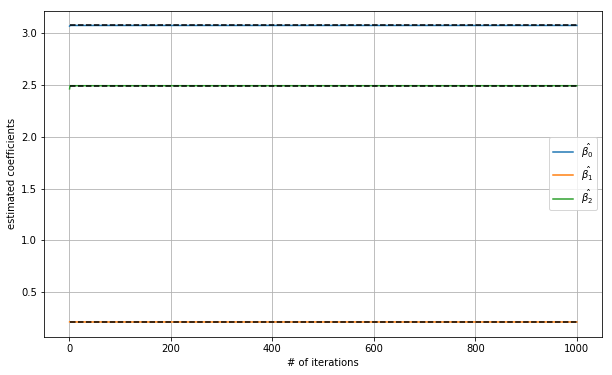

In [12]:
plt.figure(figsize=(10,6))
plt.plot(range(1,1001), beta0_lst, label = r'$\hat{\beta_{0}}$')
plt.plot(range(1,1001), beta1_lst, label = r'$\hat{\beta_{1}}$')
plt.plot(range(1,1001), beta2_lst, label = r'$\hat{\beta_{2}}$')
plt.plot(range(1,1001), [params[0]]*1000, color = 'black', linestyle = 'dashed')
plt.plot(range(1,1001), [params[1]]*1000, color = 'black', linestyle = 'dashed')
plt.plot(range(1,1001), [params[2]]*1000, color = 'black', linestyle = 'dashed')
plt.xlabel("# of iterations"); plt.ylabel("estimated coefficients")
plt.grid()
plt.legend()
plt.show()

As we can observe from the plot, the estimates derived from back-fitting methods will approximately converge to the OLS estimation.

### On this data set, how many backfitting iterations were required in order to obtain a “good” approximation to the multiple regression coefficient estimates?

In [13]:
print("Number of iterations for beta0 to converge is: {}".format(beta0_lst.index(beta0_lst[-1])))
print("Number of iterations for beta1 to converge is: {}".format(beta1_lst.index(beta1_lst[-1])))
print("Number of iterations for beta2 to converge is: {}".format(beta2_lst.index(beta2_lst[-1])))

Number of iterations for beta0 to converge is: 5
Number of iterations for beta1 to converge is: 5
Number of iterations for beta2 to converge is: 5


It takes only five iterations for the backfitting to obtain a "good" approximation to the OLS estimates.

## Backfitting with large P

In [14]:
X = sm.add_constant(np.random.normal(size = (1000, 100)))
eps = np.random.normal(size = 1000)
beta = np.random.uniform(0, 10, 101)

Y = np.dot(X, beta) + eps

In [15]:
# do the back-fitting process
beta_lst = np.ones(shape = (101,101))
mse_lst = []
for i in range(1,101):
    for j in range(101):
        beta_lst[j,i] = sm.OLS(Y - np.dot(X[:,np.arange(101)!=j], beta_lst[np.arange(101)!=j,i-1]), X[:,j]).fit().params[0]
    mse_lst.append(mean_squared_error(Y, np.dot(X, beta_lst[:,i])))

In [16]:
# do the regular OLS estimation
res = sm.OLS(Y,X).fit()
mse_ols = mean_squared_error(Y, res.fittedvalues)

In [17]:
print("The MSE using OLS regression is {}".format(mse_ols))

The MSE using OLS regression is 0.8388775268277755


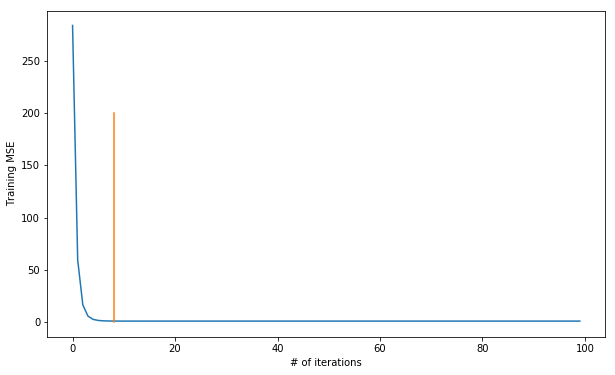

In [18]:
plt.figure(figsize=(10,6))
plt.plot(range(100), mse_lst)
idx = list(np.array(mse_lst) <= 0.91).index(True)
plt.plot([idx, idx], [0,200])
plt.xlabel("# of iterations"); plt.ylabel("Training MSE")
plt.show()

It took approximately 12 iterations to reach a good approximation to the OLS estimation, in terms of training set MSE.